# Fitting Gaussian Mixture on a data sample using features from a pre-trained Model

Consider the set of all $K$-dimensional categorical distributions given by

\begin{equation}
    \mathcal{C} = \bigg\{ \mathbf{c} \in \mathbb{R}^{K}_{+} :  \mathbf{c} \geq 0,\ \mathbf{c}^{\rm T}\mathbf{1} = 1 \bigg\} \subset \mathbb{R}^{K}_{+}.
\end{equation}

In this code we consider the set of gaussian mixtures for the set of distributions $\{ \nu_{i} \}_{i = 1}^{K} $ given by given by:
\begin{equation}
		\mathcal{GM} \bigg(\mathbf{c}, \{ \nu_{i} \}_{i = 1}^{K} \bigg) = \bigg\{ \sum_{i = 1}^{K} c_{i} \nu_{i}, \ \forall \mathbf{c} \in \mathcal{C} \bigg\}
	\end{equation}
For the mixture of gaussian distributions $\{ \nu_{i} \}_{i = 1}^{K} $ with means $\{ \mu_{i} \}_{i = 1}^{K} $ and covariance matrices $\{ \Sigma_{i} \}_{i = 1}^{K} $, mixture means and covariance are


\begin{gather*}
 \bar{\mu}_{\mathbf{c}} = \sum_{k =1}^{K} c_{k} \mu_{k}\  \text{,  }
 \,\,\,\, \tilde{\Sigma}_{\mathbf{c}} = \sum_{k =1}^{K} c_k \big( \Sigma_k + \mu_{k} \mu_{k}^{\top} - \bar{\mu}_{\mathbf{c}} \bar{\mu}_{\mathbf{c}}^\top \big)
\end{gather*}

For a data sample $\nu_{*}$, we employed Frank-Wolfe Based optimization routine to find the best matching mean, covaraince pair from the the set of all possible mixtures of $\{ \nu_{i} \}_{i = 1}^{K} $ to fit with mean $\mu_{*}$ and covaraince $\Sigma_{*}$ of $\nu_{*}$.

In [2]:
#%%
import numpy as np
import scipy as sp
from scipy.optimize import check_grad
from scipy.optimize import approx_fprime
from matplotlib import pyplot as plt

'''
    mx: mean of source with size: n x 1
    M: means of target distributions with size: n x K, where K indicates number of data-classes.
    covx: covariance matrix of source with size: n x n
    covM: array of covariance matrices of target distributions with size: K x n x n, where K indicates number of data-classes.
    max_iter: max_iterations of Frank Wolfe
    divg: divergences to be used for computations
    max_iter: maximum of frank wolfe iterations
    min_tol: minimum tolerance for gardient checking-not used in the class but kept for future updates
    print_iter: priniting values of maixture weights for each iteration
'''
class GM_FW:
    def __init__(self, mux, M, covx, covM, c0, eta, max_iter = None, min_tol = None, print_iter = None):
        # instance attributes which should be initilzied with class
        self.mux = mux
        self.M = M
        self.covx = covx
        self.covM = covM
        self.c0 = c0
        self.sqrt_covx = np.real(sp.linalg.sqrtm(covx))  
        self.sqrt_covx = (self.sqrt_covx + self.sqrt_covx.T) /2
        self.I = np.identity(np.size(mux), dtype=np.float64)

        # attributes to be keep track of computations
        self.c = np.zeros_like(c0, dtype=np.float64)
        self.mubar = np.zeros_like(mux, dtype=np.float64)
        self.hat_covM = self.covM + self.M.T.reshape([self.M.shape[1], self.M.shape[0], 1]) @ self.M.T.reshape([M.shape[1], 1, M.shape[0]])
        self.tilde_covM = np.zeros_like(covM, dtype=np.float64)
        self.tilde_sigma_c = np.zeros([covM.shape[1], covM.shape[2]],dtype=np.float64)
        self.zeta_c = np.zeros([covM.shape[1], covM.shape[2]], dtype=np.float64)
        
        if max_iter == None:
            self.max_iter = 1000
        else:
            self.max_iter = max_iter

        if min_tol == None:
            self.min_tol = 1e-6
        else:
            self.min_tol = min_tol
        
        if print_iter == None:
            self.print_iter = False
        elif print_iter == False:
            self.print_iter = False
        elif print_iter == True:
            self.print_iter = True
        else:
            self.print_iter = False

        self.obj_vals = np.zeros([self.max_iter], dtype=np.float64)
        self.grads = np.zeros([self.max_iter, np.size(self.c)], dtype=np.float64)
        self.weights = np.zeros([self.max_iter, np.size(self.c)], dtype=np.float64)
        self.eta = eta
        
    # Method to reset values of variables for new run
    def reset_values(self):

        self.sqrt_covx = sp.linalg.sqrtm(self.covx)
        self.sqrt_covx = (self.sqrt_covx + self.sqrt_covx.T) /2
        self.I = np.identity(np.size(self.mux))

        # attributes to be keep track of computations
        self.c = np.zeros_like(self.c0)
        self.mubar = np.zeros_like(self.mux)
        self.hat_covM = self.covM + \
            self.M.T.reshape([self.M.shape[1], self.M.shape[0], 1]
                         ) @ self.M.T.reshape([self.M.shape[1], 1, self.M.shape[0]])
        self.tilde_covM = np.zeros_like(self.covM)
        self.tilde_sigma_c = np.zeros([self.covM.shape[1], self.covM.shape[2]])
        self.zeta_c = np.zeros([self.covM.shape[1], self.covM.shape[2]])

        self.obj_vals = np.zeros([self.max_iter])
        self.grads = np.zeros([self.max_iter, np.size(self.c)])
        self.weights = np.zeros([self.max_iter, np.size(self.c)])
        
    # Weight initialization method to to start Frank-Wolfe Algorithm
    def initialize_weights(self):
        self.c = self.c0

    # Method to update bar{\mu} = Mc
    def update_mubar(self):
        self.mubar =  np.sum(self.c[np.newaxis,:] * self.M, axis = 1, keepdims = True)

    # MMD objective function
    def compute_mmd(self):
        return np.linalg.norm(self.mux - self.M@self.c)**2

    # MMD gradient
    def compute_mmd_grad(self):
        return 2*self.M.T @ (self.M @ self.c[:,np.newaxis] - self.mux)

    # Method to compute \tilde{\Sigma_{k}} = \Sigma_{k} + \mu_{k}\mu_{k}^{T} - \bar{\mu} \bar{\mu}^{T}
    def update_tilde_covM(self):
        self.tilde_covM = self.hat_covM - (self.mubar@self.mubar.T)[np.newaxis,:,:]

    # Method to compute \tilde{\Sigma_{\mathbf{c}}} = \sum_{c} \tilde{\Sigma_{c}}
    def update_tilde_sigma_c(self):
        self.tilde_sigma_c = np.sum(
            self.c[:, np.newaxis, np.newaxis] * self.tilde_covM, axis=0)

    # Method to compute the regularized last part of bures objective, 
    # which is used both in bures objective and its gradient
    # Tr(\Sigma_{x}^{1/2} @ \tilde{\Sigma_{\mathbf{c}}} @ \Sigma_{x}^{1/2} + \eta/4 * I)^{1/2}
    def update_zeta_c(self):
        temp = sp.linalg.sqrtm(self.sqrt_covx@self.tilde_sigma_c@self.sqrt_covx +  self.eta **4 /4 * self.I)
        temp = np.real(temp)
        self.zeta_c = (temp + temp.T)/2

   # Regularized and unregulrized Bures objetives
    def compute_bures(self):
        if self.eta == 0:
            return np.trace( self.covx + self.tilde_sigma_c - 2 * self.zeta_c )
        else:
            sign, val = np.linalg.slogdet(2*self.zeta_c + self.eta**2 * self.I)
            if sign <= 0:
                raise Exception("error: determinant is non-positive")
            B = np.trace( self.covx + self.tilde_sigma_c - 2 * self.zeta_c )
            B = B + self.covx.shape[0]*self.eta**2 * (1 - np.log(2*self.eta**2))
            B = B + self.eta**2 * val 
            return B
        
    # Bures gradient with Respect to \Sigma_{\mathbf{c}} as computed in:
    # proposition 6 from https://papers.nips.cc/paper/2020/file/766e428d1e232bbdd58664b41346196c-Paper.pdf
    def compute_bures_grad_tilde_sigma_c(self):
        return self.I - self.sqrt_covx @ sp.linalg.pinv(self.zeta_c + self.eta **2 /2 * self.I) @ self.sqrt_covx
    
    # Bures Gradient with respect to \mathbf{c}
    def compute_bures_grad_c(self):
        G = self.compute_bures_grad_tilde_sigma_c()
        rho = (self.M.T.reshape(self.M.shape[1], self.M.shape[0],1) @ self.mubar.T) + self.mubar @ self.M.T.reshape(self.M.shape[1],1,self. M.shape[0])
        temp = np.sum(G[np.newaxis, :, :] * (self.hat_covM - rho ), axis=(1, 2))[:, np.newaxis]
        return temp

    # Frechet Objective as sum of bures and MMD objectives
    def compute_frechet(self):
        B = self.compute_bures()
        mmd = self.compute_mmd()
        return B + mmd

    # Frechet gradient as sum of bures and MMD gradients
    def compute_frechet_grad(self):
        GB = self.compute_bures_grad_c()
        Gmmd = self.compute_mmd_grad()
        return GB + Gmmd
    
    # Frank Wolfe Routine for Frechet
    def FW_frechet_routine(self):
        self.initialize_weights()
        for i in range(0, self.max_iter):
            self.update_mubar()
            self.update_tilde_covM()
            self.update_tilde_sigma_c()
            self.update_zeta_c()
            self.compute_bures_grad_c()
            self.obj_vals[i] = self.compute_frechet()
            g = self.compute_frechet_grad()
            #print(g)
            self.grads[i, :] = np.squeeze(g)
            s = np.zeros_like(self.c)
            idx = np.argmin(g)
            s[idx] = 1
            gamma = 2 / (2 + i)
            self.c = (1 - gamma) * self.c + gamma * s
            
            self.weights[i, :] = self.c
            if self.print_iter == True:
                print("iter = ",i)
                print(self.c)
    
    # Frank Wolfe Routine for Bures
    def FW_bures_routine(self):
        self.initialize_weights()
        for i in range(0, self.max_iter):
            self.update_mubar()
            self.update_tilde_covM()
            self.update_tilde_sigma_c()
            self.update_zeta_c()
            self.obj_vals[i] = self.compute_bures()
            g = self.compute_bures_grad_c()
            s = np.zeros_like(self.c)
            idx = np.argmin(g)
            s[idx] = 1
            gamma = 2 / (2 + i)
            self.c = (1 - gamma) * self.c + gamma * s
            self.grads[i, :] = np.squeeze(g)
            self.weights[i, :] = self.c

            if self.print_iter == True:
                print("iter =  ",i)
                print(self.c)
    
    # Frank Wolfe Routine for MMD
    def FW_MMD_routine(self):
        self.initialize_weights()
        for i in range(0, self.max_iter):
            self.update_mubar()
            self.update_tilde_covM()
            self.obj_vals[i] = self.compute_mmd()
            g = self.compute_mmd_grad()
            s = np.zeros_like(self.c)
            idx = np.argmin(g)
            s[idx] = 1
            gamma = 2 / (2 + i)
            self.c = (1 - gamma) * self.c  + gamma * s 
            self.grads[i,:] = np.squeeze(g)
            self.weights[i,:] = self.c

            if self.print_iter == True:
                print("iter = ",i)
                print(self.c)

def Hellinger(p, q):
  '''
  Function to evaluate Hellinger Distance between categorical distributions p and q
  input: distributions p and q of same size
  outputs: Hillnger distance between p and q

  '''
  assert np.all(p >= 0), "first distribution must be non-negative"
  assert np.all(q >= 0), "second distribution must be non-negative"
  assert p.size == q.size, "input vectors must be of same size"

  p = p.reshape([p.size, 1])
  q = q.reshape([q.size, 1])

  return (1/np.sqrt(2)) * np.linalg.norm(np.sqrt(p) - np.sqrt(q))


Testing on Gaussians in 2D, which are easily visualizible

In [3]:
import numpy as np
import scipy as sp

#M = np.array([[0, -0.5, 0.5],[1, 0, 0]])
M = np.array([[0, 0, 0], [0, 0, 0]])
#M = np.ones_like(M)
mux = np.array([[np.sqrt(3)/2], [np.sqrt(3)/2] ])
covx = np.array([[10,6],[6,8]])
covM = np.zeros([3,2,2])
covM[0] = np.array([[1, 0.5],[0.5, 1]]) 
covM[1] = np.array([[5, 0.6], [0.6, 7]])
covM[2] = np.array([[4, 1], [1, 2]])

#mux = np.mean(M, axis = 1, keepdims = True)
#mux = np.array([[1], [1] ])
#covx = 1/3 * covM[0] + 2/3 * covM[1] + 0/3 * covM[1]


c0 = np.ones(3)/3
 
iterations = 1000

test = GM_FW(mux, M, covx, covM, c0, eta = 0.000, max_iter = iterations, print_iter = True)
test.reset_values()
#test.FW_bures_routine()
test.FW_frechet_routine()
#test.reset_values()

iter =  0
[0. 1. 0.]
iter =  1
[0.         0.33333333 0.66666667]
iter =  2
[0.         0.66666667 0.33333333]
iter =  3
[0.  0.8 0.2]
iter =  4
[0.         0.86666667 0.13333333]
iter =  5
[0.        0.9047619 0.0952381]
iter =  6
[0.         0.92857143 0.07142857]
iter =  7
[0.         0.94444444 0.05555556]
iter =  8
[0.         0.95555556 0.04444444]
iter =  9
[0.         0.78181818 0.21818182]
iter =  10
[0.         0.81818182 0.18181818]
iter =  11
[0.         0.84615385 0.15384615]
iter =  12
[0.         0.86813187 0.13186813]
iter =  13
[0.         0.88571429 0.11428571]
iter =  14
[0.  0.9 0.1]
iter =  15
[0.         0.91176471 0.08823529]
iter =  16
[0.         0.92156863 0.07843137]
iter =  17
[0.         0.92982456 0.07017544]
iter =  18
[0.         0.93684211 0.06315789]
iter =  19
[0.         0.94285714 0.05714286]
iter =  20
[0.         0.94805195 0.05194805]
iter =  21
[0.         0.95256917 0.04743083]
iter =  22
[0.         0.87318841 0.12681159]
iter =  23
[0.       

In [22]:
#test.weights

In [23]:
# num_ptx = 10
# dim = 100

# np.random.seed(2021)
# M = np.random.rand(dim, num_ptx)
# #M = np.zeros([dim, num_ptx])
# #M = np.ones_like(M)
# mux = np.random.rand(dim).reshape([dim, 1])
# A = np.random.rand(dim, dim)
# covx = A @ A.T
# covM = np.zeros([num_ptx, dim, dim])
# for i in range(0, num_ptx):
#     A = np.random.rand(dim, dim)
#     covM[i] = A @ A.T +  0 * np.identity(dim)

# iterations = 1000
# #
# c0 = np.ones(num_ptx)/(num_ptx)
# test = GM_FW(mux, M, covx, covM, c0, eta = 0, max_iter=iterations, print_iter = True)
# #test.reset_values()
# test.FW_bures_routine()


In [24]:
# import matplotlib.pyplot as plt
# import numpy as np
# import tensorflow as tf
# import keras
# from numpy.random import exponential
# from sklearn.decomposition import PCA

# np.random.seed(2021)

# # Data Processing before PCA 
# # N_samples indicates the number of samples to be drawn from data
# N_samples = 1
# # sample_sz indicates the number of samples to be drawn from data
# sample_sz = 400

# tf.keras.datasets.mnist.load_data(path="mnist.npz")
# (X_train, y), (X_test, yt) = keras.datasets.mnist.load_data()

# X_train = X_train / 255
# y = y / 1
# X_test = X_test / 255
# yt = yt / 1

# X = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
# Xt = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

# # PCA from scikit-learn
# PCA_components = 130
# pca = PCA(n_components = PCA_components)
# pca.fit(X)
# # np.sum(pca.explained_variance_ratio_)
# P = pca.components_
# X_hat = X@P.T
# Xt_hat = Xt@P.T

# # Creation and Testing and Training samples

# n_classes = np.size(np.unique(y))
# means_i = np.zeros([n_classes, PCA_components])
# covs_i = np.zeros([n_classes, PCA_components, PCA_components])

# Training_Data = {}
# Training_Lables = {}
# for i in range(0, 10):
#   Training_Data[str(i)] = X_hat[y == i]
#   Training_Lables[str(i)] = y[y == i]
#   means_i[i] = np.mean(Training_Data[str(i)], axis = 0)
#   covs_i[i] = np.cov(Training_Data[str(i)].T)

# Testing_Data = {}
# Testing_Lables = {}
# for i in range(0, 10):
#   Testing_Data[str(i)] = Xt_hat[yt == i]
#   Testing_Lables[str(i)] = yt[yt == i]

# FW_iterations = 10
# Hellinger_metric = np.zeros([N_samples, FW_iterations])
# Grads = np.zeros([N_samples, FW_iterations, n_classes])
# Optimal_weights = np.zeros([N_samples, FW_iterations, n_classes])
# Sample_distributions = np.zeros([N_samples, n_classes])

# for sample_iter in range(0, N_samples): 
#   # sampling uniformly on probability simplex
#   sz = exponential(1, n_classes)
#   s = sz / np.sum(sz)
#   ints = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
#   p = s
#   counts_sample = np.floor(sample_sz * p)
#   Sample_distributions[sample_iter,:] = counts_sample / np.sum(counts_sample)

#   sample = np.empty([0, PCA_components], dtype = float)
#   sample_labels = np.empty(0, dtype = float)
#   counter = 0
#   for k in ints:
#     idx = np.random.choice(np.arange(0, Testing_Data[str(k)].shape[0]), size = np.int(counts_sample[counter]), replace = False )
#     sample = np.append(sample, Testing_Data[str(k)][idx], axis = 0)
#     sample_labels = np.append(sample_labels, Testing_Lables[str(k)][idx], axis = 0)
#     counter = counter + 1

#   mean_x = np.mean(sample, axis = 0)
#   covx = np.cov(sample.T)

#   mux = mean_x[np.newaxis,:].T
#   M = means_i.T
#   covM = covs_i
  
#   # Frank_Wolfe is invoked
#   c0 = np.ones(n_classes)/n_classes
  
#   MNIST = GM_FW(mux, M, covx, covM, c0, eta = 0, max_iter = FW_iterations, print_iter = True)
  
#   MNIST.FW_bures_routine()
#   Optimal_weights[sample_iter] = MNIST.weights
#   Grads[sample_iter] = MNIST.grads
#   print("sample = ", sample_iter)

# # for i in range(0, N_samples):
# #     for j in range(0, FW_iterations):
# #         Hellinger_metric[i, j] = Hellinger(Sample_distributions[i], Optimal_weights[i, j, :])

# # from tempfile import TemporaryFile
# # MNIST_data = TemporaryFile()
# # np.savez("MNIST_data", Optimal_weights=Optimal_weights, Grads=Grads, \
# #          Sample_distributions=Sample_distributions, Hellinger_metric=Hellinger_metric)


In [100]:
from tempfile import TemporaryFile
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import exponential

import pickle

def LoadFile(file_name):
  with open(file_name,'rb') as f:
    data = pickle.load(f)
  return data


# Data Processing before PCA 
# N_samples indicates the number of samples to be drawn from data
N_samples = 10
Hellinger_distances = np.zeros([N_samples, 1])
# sample_sz indicates the number of samples to be drawn from data
sample_sz = 500

X = LoadFile('x_train_Cifar10_VGG16_512.pkl')
Xt = LoadFile('x_test_Cifar10_VGG16_512.pkl')
y = LoadFile('y_train_Cifar10_VGG16_512.pkl')
yt = LoadFile('y_test_Cifar10_VGG16_512.pkl')
y = np.squeeze(y)
yt = np.squeeze(yt)

n_classes = np.size(np.unique(y))
means_i = np.zeros([n_classes, X.shape[1]])
covs_i = np.zeros([n_classes,X.shape[1], X.shape[1]])

Training_Data = {}
Training_Lables = {}
for i in range(0, 10):
  Training_Data[str(i)] = X[y == i]
  Training_Lables[str(i)] = y[y == i]
  means_i[i] = np.mean(Training_Data[str(i)], axis = 0)
  covs_i[i] = np.cov(Training_Data[str(i)].T)

Testing_Data = {}
Testing_Lables = {}
for i in range(0, 10):
  Testing_Data[str(i)] = Xt[yt == i]
  Testing_Lables[str(i)] = yt[yt == i]

FW_iterations = 200
Hellinger_metric = np.zeros([N_samples, FW_iterations])
Grads = np.zeros([N_samples, FW_iterations, n_classes])
Optimal_weights = np.zeros([N_samples, FW_iterations, n_classes])
Sample_distributions = np.zeros([N_samples, n_classes])

for sample_iter in range(0, N_samples): 
  # sampling uniformly on probability simplex
  sz = exponential(1, n_classes)
  s = sz / np.sum(sz)
  ints = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  p = s
  counts_sample = np.floor(sample_sz * p)
  Sample_distributions[sample_iter,:] = counts_sample / np.sum(counts_sample)

  sample = np.empty([0, X.shape[1]], dtype = float)
  sample_labels = np.empty(0, dtype = float)
  counter = 0
  for k in ints:
    idx = np.random.choice(np.arange(0, Testing_Data[str(k)].shape[0]), size = np.int(counts_sample[counter]), replace = False )
    sample = np.append(sample, Testing_Data[str(k)][idx], axis = 0)
    sample_labels = np.append(sample_labels, Testing_Lables[str(k)][idx], axis = 0)
    counter = counter + 1

  mean_x = np.mean(sample, axis = 0)
  covx = np.cov(sample.T)

  mux = mean_x[np.newaxis,:].T
  M = means_i.T
  covM = covs_i
  
  # Frank_Wolfe is invoked
  c0 = np.ones(n_classes)/n_classes
  
  CIFAR10_VGG16 = GM_FW(mux, M, covx, covM, c0, eta=10,
                        max_iter=FW_iterations, print_iter=False)
  
  CIFAR10_VGG16.FW_frechet_routine()
  Optimal_weights[sample_iter] = CIFAR10_VGG16.weights
  Grads[sample_iter] = CIFAR10_VGG16.grads
  print("sample = ", sample_iter)

for i in range(0, N_samples):
    for j in range(0, FW_iterations):
        Hellinger_metric[i, j] = Hellinger(Sample_distributions[i], Optimal_weights[i, j, :])

# CIFAR10_VGG16_data = TemporaryFile()
# np.savez("CIFAR10_VGG16_data", Optimal_weights=Optimal_weights, Grads=Grads,
#          Sample_distributions=Sample_distributions, Hellinger_metric=Hellinger_metric)


sample =  0
sample =  1
sample =  2
sample =  3
sample =  4
sample =  5
sample =  6
sample =  7
sample =  8
sample =  9


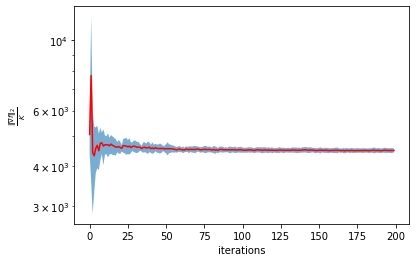

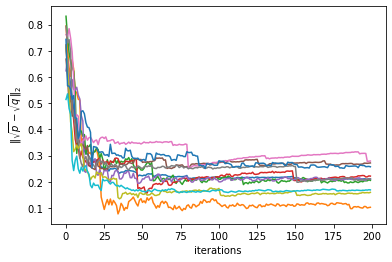

In [102]:
fig, ax = plt.subplots()


iters = np.array([k for k in range(0, FW_iterations)])
Grads_norms = np.linalg.norm(Grads/n_classes, axis=0)
Grads_norms_means = np.mean(Grads_norms, axis=1)
Grads_norms_std = np.std(Grads_norms, axis=1)
plt.semilogy(iters, Grads_norms_means, color='r')
plt.fill_between(iters, Grads_norms_means - Grads_norms_std,
                 Grads_norms_means + Grads_norms_std, alpha=0.6)
plt.xlabel("iterations")
plt.ylabel('$ \\frac{\Vert\\nabla f \Vert_{2}}{K}$')
plt.show()

Hellinger_means = np.mean(Hellinger_metric.T, axis=1)
Hellinger_std = np.std(Hellinger_metric.T, axis=1)
#plt.semilogy(iters, (Hellinger_metric.T))
plt.plot(iters, Hellinger_means)
plt.plot(Hellinger_metric.T)
# plt.fill_between(iters, Hellinger_means - Hellinger_std,
#                  Hellinger_means + Hellinger_std, alpha=0.6)
plt.xlabel("iterations")
plt.ylabel(
    "$\ \Vert \sqrt{p} - \sqrt{q} \Vert_{2}$")
plt.show()


In [93]:
CIFAR10_VGG16.c

array([0.02930693, 0.05742574, 0.28653465, 0.        , 0.13465347,
       0.        , 0.2219802 , 0.26376238, 0.00633663, 0.        ])

In [98]:
1-Hellinger(CIFAR10_VGG16.c, s)**2
#np.linalg.norm(CIFAR10_VGG16.c-s)
s


array([0.03674977, 0.07478753, 0.4270793 , 0.06673451, 0.05234886,
       0.00924267, 0.14341119, 0.15318643, 0.0274122 , 0.00904755])

In [55]:
for i in range(0, covs_i.shape[0]):
    print(np.all(covs_i[i ]== covs_i[i].T))
    print(np.linalg.eigvalsh(covs_i[i]))

True
[3.83375552e-14 1.12408687e-12 1.96340814e-04 ... 9.27784065e+04
 2.93879631e+05 3.53434081e+05]
True
[-1.81782230e-13 -2.71990769e-17  1.41385590e-03 ...  1.00987804e+05
  2.82825891e+05  2.95069214e+05]
True
[-1.92736377e-12  3.17267228e-04  4.88677242e-04 ...  6.88614494e+04
  1.95322356e+05  2.85996934e+05]
True
[-1.01653071e-14  7.37822609e-14  3.02138660e-04 ...  8.09922027e+04
  2.60595387e+05  2.68726680e+05]
True
[-4.58279472e-17  1.86354367e-15  1.61875919e-14 ...  6.79171180e+04
  1.97274161e+05  2.26980212e+05]
True
[-1.20422107e-14  7.18521108e-17  2.47701854e-12 ...  1.08263349e+05
  2.10049129e+05  2.83155286e+05]
True
[8.78894749e-15 2.00862706e-12 7.05356872e-04 ... 1.06125664e+05
 1.84869644e+05 2.55261990e+05]
True
[-2.15673930e-18  1.45737749e-14  2.83365166e-13 ...  9.34842451e+04
  2.09536203e+05  2.73619073e+05]
True
[-4.09352220e-13 -9.84400632e-14  1.77810270e-17 ...  9.32383240e+04
  2.27768808e+05  3.02323225e+05]
True
[1.15135440e-12 1.73264276e-04 2.69

In [64]:
for i in range(0, covs_i.shape[0]):
    for j in range(0, covs_i.shape[0]):
        print( np.linalg.norm(covs_i[i] - covs_i[j], ord = 'fro') )

0.0
171354.38769853624
163334.76941555872
156433.55390648486
186483.17991134652
198959.62698350614
219287.70661481735
192355.93137983905
171812.257392717
225244.67861852085
171354.38769853624
0.0
183973.04497587468
137040.79483937487
174330.90095647553
168470.84572068902
178332.3640390809
161124.75467175938
165910.85195796457
127089.63764524643
163334.76941555872
183973.04497587468
0.0
113643.08489506297
87899.8435381585
152830.3298313368
130726.36272509243
143896.83686515153
194906.3064224918
186771.5804566617
156433.55390648486
137040.79483937487
113643.08489506297
0.0
113176.73669471905
86993.20101188352
127905.2036329166
128177.77301419074
149654.0640443293
166405.6907993815
186483.17991134652
174330.90095647553
87899.8435381585
113176.73669471905
0.0
134035.27289964896
118721.55301428834
121699.7501063512
162356.46768927728
173223.21113889068
198959.62698350614
168470.84572068902
152830.3298313368
86993.20101188352
134035.27289964896
0.0
142213.75260295387
118748.01711187068
16634

In [71]:
for i in range(0, covs_i.shape[0]):
    for j in range(0, covs_i.shape[0]):
        print( np.linalg.norm(M[:,i] - M[:,j]) )

0.0
341.51507470335383
422.4247859351434
377.53352322946137
454.9555941805132
389.5170101283486
548.8112469628584
427.859624925202
195.66708419437438
471.18522652555345
341.51507470335383
0.0
405.6970563031867
321.60428266701206
409.9680549422441
323.9156979529624
408.42127802194597
306.5818435677959
364.717596261466
238.39170641914615
422.4247859351434
405.6970563031867
0.0
177.35041300200206
96.28074076069788
261.4844844499535
255.47287413740645
242.40553452140895
504.6963227031405
439.1338662834322
377.53352322946137
321.60428266701206
177.35041300200206
0.0
179.11764944654195
136.0897772903951
250.62793918123165
266.1108231714618
418.7627735933172
412.4215054914685
454.9555941805132
409.9680549422441
96.28074076069788
179.11764944654195
0.0
272.56271103809877
222.34550652027463
281.56750207664334
513.6390230554665
460.07386063572505
389.5170101283486
323.9156979529624
261.4844844499535
136.0897772903951
272.56271103809877
0.0
299.93348624442456
295.16307079746946
430.3248723064433


In [70]:
M.shape

(2048, 10)

In [40]:
np.linalg.norm(means_i[3] - means_i[5])

61.150371640124305

In [41]:
self.Weights

NameError: name 'self' is not defined